# 加载并查看数据
## 加载数据

In [54]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import re
import jieba
train = pd.read_csv("./data/train.csv", sep="###__###",header = None,index_col=False)
train.columns = ['ID', 'Age', 'Gender', 'Education', 'Query_List']
print(train.size)
train.head(1)

500000


,ID,Age,Gender,Education,Query_List
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...


In [2]:
# test = pd.read_csv("./data/test.csv", sep="###__###",header = None)
# test.columns = ['ID', 'Query_List']
# test.head(1)

## 思路

不同特征的用户，搜索的信息不同

直接相关的线索：语义向量的聚类，主题，

### 执行计划

先走通流程

1. 用少量数据训练模型，调参，评估
1. 保存预处理数据和训练模型
1. 优化，降噪，增加数据

### 优化

特征工程

1. 文本结构
1. 情感分析
1. 有效文本长度比重

### 降噪
1. 自定义停用词
1. 不合理的用户（比如未成年博士）

# BOW模型

分词工具

https://github.com/fxsjy/jieba

https://github.com/thunlp/THULAC-Python

https://github.com/tsroten/pynlpir

https://github.com/rockyzhengwu/FoolNLTK

https://github.com/baidu/lac

https://github.com/hankcs/HanLP

https://github.com/isnowfy/snownlp

同义词替换

https://github.com/fighting41love/funNLP

https://github.com/huyingxi/Synonyms

近义词聚类

https://github.com/RaRe-Technologies/gensim


## 去停用词
https://github.com/goto456/stopwords



In [3]:
stopwords = pd.read_csv('./stopwords/cn_stopwords.txt',names=['sw'],index_col=False)

### 自定义停用词

In [4]:
# !cat stopwords/cn_stopwords.txt
# jieba.load_userdict('stopwords/my_stopwords.txt')

## 预处理

去除无关文本，每个分类特征，取n条数据，放到一个数组里

In [5]:
import jieba.analyse as analyse
from collections import Counter
import pickle

def dump(obj,path):
    with open(path,"wb") as f:
        pickle.dump(obj,f)
def load(obj,path):
    with open(path,"wb") as f:
        pickle.load(obj,f)
        
dimensions = ['Age','Gender','Education']

def preprocess(n):    
    t=[]
    vocab=[]
    for dimension in dimensions:
        d=[]
        C = list(set(train[dimension]))
        C.pop(0)
        for c in C:
            lines = train[train[dimension]==c]['Query_List'][:n]
            for line in lines:
                try:
                    line=re.sub(r'http\S+\s','http',line)
                    line=re.sub(r' ','空格',line)
                    segs=jieba.lcut(line)
#                     segs = analyse.extract_tags(line)
#                     segs = analyse.textrank(line)
                    segs = list(filter(lambda x:len(x)>1, segs)) #没有解析出来的过滤掉
                    segs = list(filter(lambda x:x not in stopwords, segs)) #把停用词过滤掉
                    d.append((" ".join(segs),c))#dimension+str(c)))
                    vocab.extend(segs)                
                except Exception as e:
                    print(e)
                    continue
        t.append(d)
    return t,vocab

def get_word2id(vocab,vocab_size=5000):
    counter = Counter(vocab)
    count_pairs = counter.most_common(vocab_size)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    # open_file(vocab_file, mode='w').write('\n'.join(words) + '\n')
    word2id = dict(zip(words, range(len(words))))
    return word2id

t,vocab=preprocess(300)
word2id=get_word2id(vocab)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.978 seconds.
Prefix dict has been built succesfully.


## 分类函数

以分词字典的词频为特征，就是BOW模型。

向量为One-hot

In [ ]:
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score

class TextClassifier():

    def __init__(self, classifier=MultinomialNB(),vectorizer = CountVectorizer(ngram_range=(1,4), max_features=20000)):
        self.classifier = classifier
        self.vectorizer = vectorizer

    def features(self, X):
        return self.vectorizer.transform(X)

    def fit(self, X, y):
        self.vectorizer.fit(X)
        self.classifier.fit(self.features(X), y)

    def predict(self, x):
        return self.classifier.predict(self.features([x]))

    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

    def save_model(self, path):
        dump((self.classifier, self.vectorizer), path)

    def load_model(self, path):
        self.classifier, self.vectorizer = load(path)
        
    def cv(self, X, y, kf=StratifiedKFold(n_splits=5, shuffle=True)):
        y_pred = y[:]
        for i, j in kf.split(X, y):
            self.classifier.fit(X[i], y[i])
            y_pred[j]=self.classifier.predict(X[j])
        return y_pred
    
    def cv_score(self,y,y_pred):
        return precision_score(y, y_pred, average='macro')


### MultinomialNB，CountVectorizer（默认）

In [ ]:
import random 

for i,dimension in enumerate(t):
    print(dimensions[i])
    random.shuffle(dimension)
    c = TextClassifier()
    X=[]
    y=[]
    for x,_ in dimension:
        X.append(x)
        y.append(str(_))
    x_train,x_test,y_train,y_test=train_test_split(X,y)
    c.fit(x_train,y_train)
    print(c.score(x_test,y_test))
    c.save_model("models/gxli_MNB_C_"+dimensions[i])
#     c.load_model("gxli_MNB_C.model")
    y_pred=c.cv(c.features(X),np.array(y))
    print(precision_score(y,y_pred, average='macro'))

### TfidfVector

In [ ]:
for i,dimension in enumerate(t):
    print(dimensions[i])
    random.shuffle(dimension)
    c = TextClassifier(vectorizer=TfidfVectorizer())
    X=[]
    y=[]
    for x,_ in dimension:
        X.append(x)
        y.append(str(_))
    x_train,x_test,y_train,y_test=train_test_split(X,y)
    c.fit(x_train,y_train)
    print(c.score(x_test,y_test))
    c.save_model("models/gxli_MNB_T_"+dimensions[i])
#     c.load_model("gxli_MNB_T.model")
    y_pred=c.cv(c.features(X),np.array(y))
    print(precision_score(y,y_pred, average='macro'))

### SVM

In [ ]:
from sklearn.svm import SVC
for i,dimension in enumerate(t):
    print(dimensions[i])
    random.shuffle(dimension)
    c = TextClassifier(classifier=SVC(), vectorizer=TfidfVectorizer())
    X=[]
    y=[]
    for x,_ in dimension:
        X.append(x)
        y.append(str(_))
    x_train,x_test,y_train,y_test=train_test_split(X,y)
    c.fit(x_train,y_train)
    print(c.score(x_test,y_test))
    c.save_model("models/gxli_SVC_T_"+dimensions[i])
#     c.load_model("gxli_SVC_T.model")
    y_pred=c.cv(c.features(X),np.array(y))
    print(precision_score(y,y_pred, average='macro'))

# 主题模型

## LDA
1. 先训练lda主题模型
1. 把词向量转化成主题向量,构造中间层特征（部分解决了近义词与多义词的语义特征）
1. 分类

### 训练LDA模型

保存

In [23]:
S=set()
for dimension in t:
    for x,y in dimension:
        S.add(x)
lda_data=list(S)
lda_data=[x.split(' ') for x in lda_data]

In [24]:
from gensim import corpora, models, similarities
import gensim

dictionary = corpora.Dictionary(lda_data)
corpus = [dictionary.doc2bow(x) for x in lda_data]

lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=1000)
lda.save('models/gxli_lda')

### 用分类模型分类

X格式：浮点数二维列表

y格式：整数

#### 决策树

In [25]:
from sklearn import tree

lda = models.ldamodel.LdaModel.load('models/gxli_lda')
for i,dimension in enumerate(t):
    print(dimensions[i])
    X=[]
    y=[]
    for d,c in dimension:
        bow = dictionary.doc2bow(d.split(' '))
        ndarray = lda.inference([bow])[0][0]
        X.append(ndarray.tolist())
        y.append(c)
    x_train,x_test,y_train,y_test=train_test_split(X,y)
    c=TextClassifier(classifier=tree.DecisionTreeClassifier())
    c.classifier.fit(x_train,y_train)
    print(c.classifier.score(x_test,y_test))
    c.save_model("models/gxli_lda_dt_"+dimensions[i])
#     c.load_model("models/gxli_lda_dt_"+dimensions[i])
    y_pred=c.cv(np.array(X),np.array(y))
    print(precision_score(y,y_pred, average='macro'))

Age
0.19555555555555557
0.2710263603817609
Gender
0.5866666666666667
0.6575137405603467
Education
0.2222222222222222
0.291255132534145


#### 神经网络

In [28]:
import tensorflow as tf

for dimension in t[:1]:
    print(dimensions[i])
    X=[]
    y=[]
    for d,c in dimension:
        bow = dictionary.doc2bow(d.split(' '))
        ndarray = lda.inference([bow])[0][0]
        X.append(ndarray.tolist())
        y.append(c)
    x_train,x_test,y_train,y_test=train_test_split(X,y)
    model=tf.keras.models.Sequential([tf.keras.layers.Dense(1000,
                                                         activation='softmax',
                                                         kernel_regularizer=tf.keras.regularizers.l2())])
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['sparse_categorical_accuracy'])
    model.fit(x_train,y_train,batch_size=16,epochs=100,validation_freq=20)
    model.summary()

Education


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

# DL模型
## FastText
### 监督学习

In [ ]:
import fasttext
s=set()
for i,dimension in enumerate(t):
    with open('gxli_fasttext_train_data.txt', 'w', encoding='utf-8') as out:
        for x,y in dimension:
            if not x in s:
#                 print(x)
                out.write('__label__'+dimensions[i]+str(y)+' , '+x+"\n")
#                 out.write('__label__'+dimensions[i]+y+' , '+x+"\n")
    classifier = fasttext.train_supervised(input='gxli_fasttext_train_data.txt', dim=100, epoch=5,lr=0.1, wordNgrams=2, loss='softmax')
#     classifier.save_model('gxli_fasttext.model')
    result = classifier.test('gxli_fasttext_train_data.txt')
    print(dimensions[i])
    print('P@1:', result[1])
    print('R@1:', result[2])
    print('Number of examples:', result[0])

### 无监督学习

## TextCNN

### 定义网络结构

In [102]:
# from tensorflow.keras import Input, Model
# from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout
# class TextCNN(Model):
#     def __init__(self,maxlen, max_features, embedding_dims,
#                  class_num=5,
#                  kernel_size = [3, 4, 5],
#                  last_activation='softmax'):
#         super(TextCNN, self).__init__()
#         self.eb=Embedding(max_features, embedding_dims, input_length=maxlen)#(Input((maxlen,)))
# #         self.c1=Conv1D(128, kernel_size, activation='relu')
#         self.gp=GlobalMaxPooling1D()
#         self.cc=Concatenate()
#         self.dn=Dense(class_num, activation=last_activation)
#         self.ks=kernel_size
#     def call(self, x):
#         convs = []
#         for ks in self.ks:
#             c = Conv1D(128, ks, activation='relu')(self.eb(x))
#             c = self.gp(c)
#             convs.append(c)
#         x = self.cc(convs)
#         y = self.dn(x)
#         return y

In [105]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=2,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        inputs = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(inputs)
        convs = []
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        outputs = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=inputs, outputs=outputs)
        return model

### 数据处理与训练

In [106]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# for i,dimension in enumerate(t[:1]):
d=[]
for x,y in t[0]:
    s=[word2id.get(w,0) for w in x.split(' ') ]
    d.append((s,y-1))

random.shuffle(d)
X,y=zip(*d)
X=sequence.pad_sequences(X, maxlen=1000)
y=to_categorical(y)
x_train,x_test,y_train,y_test=train_test_split(X,y)

# model = TextCNN(1000, 5001, 50,class_num=6)
model = TextCNN(1000, 5001, 50,class_num=6).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=8,
          epochs=4,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))
    

训练...
Train on 1350 samples, validate on 450 samples
Epoch 1/4
1344/1350 [============================>.] - ETA: 0s - loss: 1.7878 - accuracy: 0.1882
Epoch 00001: saving model to ./cnn_model.h5
1350/1350 [==============================] - 5s 4ms/sample - loss: 1.7881 - accuracy: 0.1874 - val_loss: 1.7674 - val_accuracy: 0.2156
Epoch 2/4
1344/1350 [============================>.] - ETA: 0s - loss: 1.6305 - accuracy: 0.4085
Epoch 00002: saving model to ./cnn_model.h5
1350/1350 [==============================] - 4s 3ms/sample - loss: 1.6299 - accuracy: 0.4081 - val_loss: 1.6975 - val_accuracy: 0.2378
Epoch 3/4
1344/1350 [============================>.] - ETA: 0s - loss: 1.4049 - accuracy: 0.5312
Epoch 00003: saving model to ./cnn_model.h5
1350/1350 [==============================] - 4s 3ms/sample - loss: 1.4039 - accuracy: 0.5311 - val_loss: 1.6304 - val_accuracy: 0.2911
Epoch 4/4
1336/1350 [============================>.] - ETA: 0s - loss: 1.0519 - accuracy: 0.7672
Epoch 00004: saving mo

### 训练中间信息输出

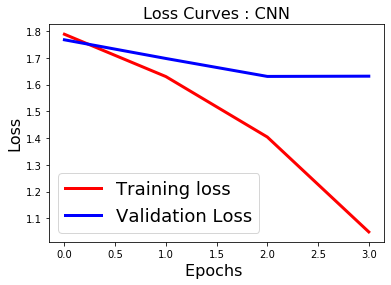

In [108]:
import matplotlib.pyplot as plt
def plot_loss(history,model_name):
    plt.switch_backend('agg')
    %matplotlib inline

    fig1 = plt.figure()
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves : '+model_name,fontsize=16)
    fig1.savefig(model_name+'_loss.png')
    plt.show()
plot_loss(history,'CNN')

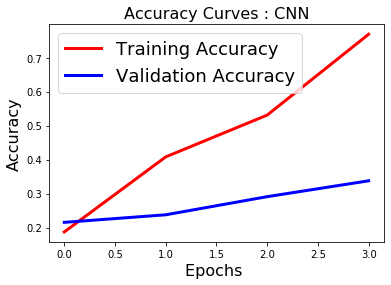

In [110]:
def plot_acc(history,model_name):
    fig2=plt.figure()
    # print(history.history)
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves : CNN',fontsize=16)
    fig2.savefig('accuracy_cnn.png')
    plt.show()

plot_acc(history,'CNN')

### 模型结构打印

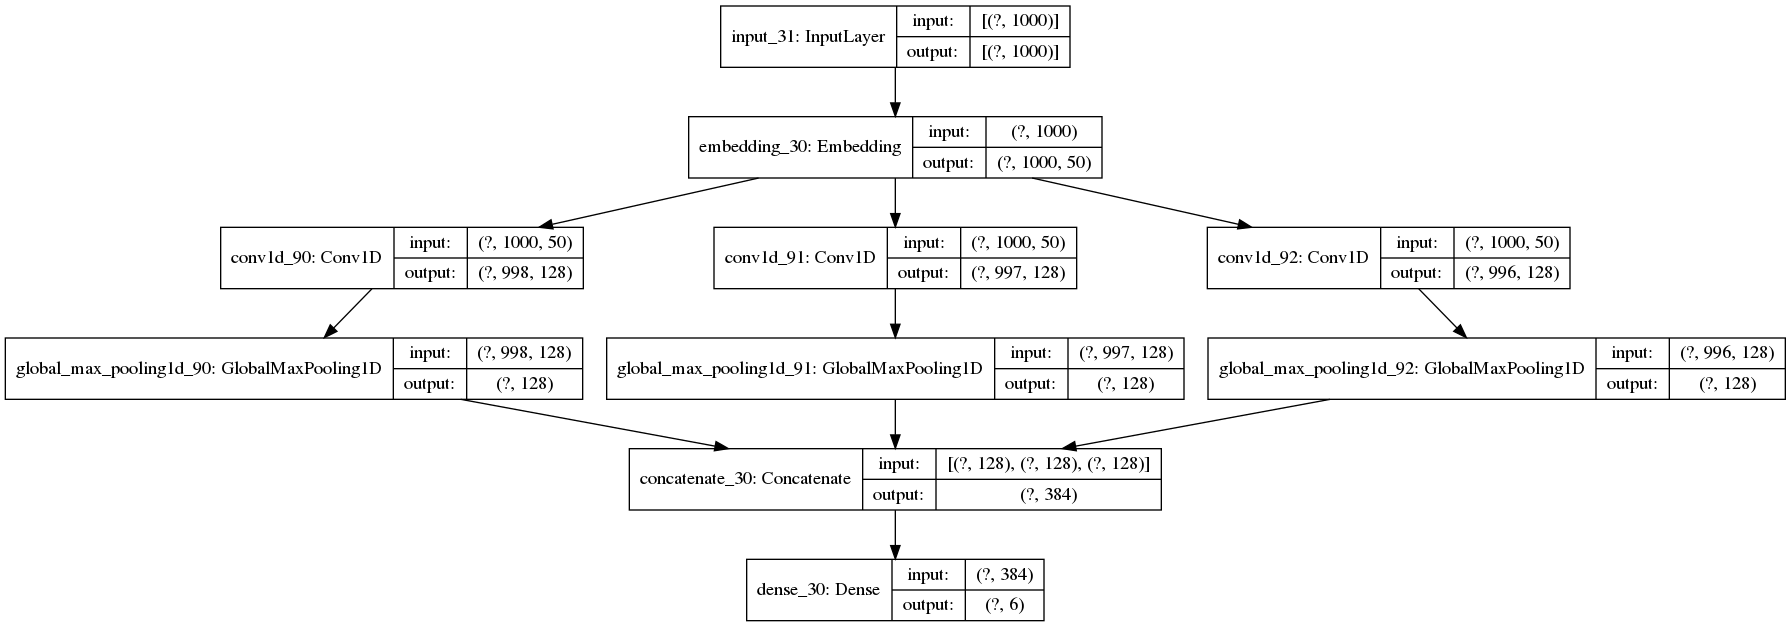

In [79]:
from tensorflow.keras.utils import plot_model
# model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

## TextRNN
### 定义网络结构

In [107]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM


class TextRNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        inputs = Input((self.maxlen,))

        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(inputs)
        x = LSTM(128)(embedding)

        outputs = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=inputs, outputs=outputs)
        return model

### 数据处理和训练

In [ ]:
model = TextRNN(1000, 5001, 50,class_num=6).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('Train...')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
history = model.fit(x_train, y_train,
          batch_size=8,
          epochs=4,
          callbacks=[early_stopping],
          validation_data=(x_test, y_test))

Train...
Train on 1350 samples, validate on 450 samples
Epoch 1/4
 728/1350 [===============>..............] - ETA: 5s - loss: 1.7914 - accuracy: 0.1813

In [ ]:
plot_loss(history,'RNN')

In [ ]:
plot_acc(history,'RNN')